In [158]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers

import keras_cv
from keras_cv import bounding_box
import os
from luketils import visualization

BATCH_SIZE = 16
EPOCHS = 100
CHECKPOINT_PATH = os.getenv("CHECKPOINT_PATH", "checkpoint/")

In [159]:
dataset, dataset_info = keras_cv.datasets.pascal_voc.load(
    split="train", bounding_box_format="xywh", batch_size=9
)

class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [160]:
image_size = [640, 640, 3]
train_ds = tfds.load(
    "voc/2007", split="train+test", with_info=False, shuffle_files=True
)
train_ds = train_ds.concatenate(
    tfds.load("voc/2012", split="train+validation", with_info=False, shuffle_files=True)
)
eval_ds = tfds.load("voc/2007", split="test", with_info=False)

In [161]:
train_ds

<ConcatenateDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'labels_no_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'objects': {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'is_difficult': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'is_truncated': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pose': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>

In [162]:
eval_ds

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'labels_no_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'objects': {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'is_difficult': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'is_truncated': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pose': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>

In [163]:
# TODO: migrate to KPL.
def resize_and_crop_image(
    image,
    desired_size,
    padded_size,
    aug_scale_min=1.0,
    aug_scale_max=1.0,
    seed=1,
    method=tf.image.ResizeMethod.BILINEAR,
):
    with tf.name_scope("resize_and_crop_image"):
        image_size = tf.cast(tf.shape(image)[0:2], tf.float32)

        random_jittering = aug_scale_min != 1.0 or aug_scale_max != 1.0

        if random_jittering:
            random_scale = tf.random.uniform(
                [], aug_scale_min, aug_scale_max, seed=seed
            )
            scaled_size = tf.round(random_scale * desired_size)
        else:
            scaled_size = desired_size

        scale = tf.minimum(
            scaled_size[0] / image_size[0], scaled_size[1] / image_size[1]
        )
        scaled_size = tf.round(image_size * scale)

        # Computes 2D image_scale.
        image_scale = scaled_size / image_size

        # Selects non-zero random offset (x, y) if scaled image is larger than
        # desired_size.
        if random_jittering:
            max_offset = scaled_size - desired_size
            max_offset = tf.where(
                tf.less(max_offset, 0), tf.zeros_like(max_offset), max_offset
            )
            offset = max_offset * tf.random.uniform(
                [
                    2,
                ],
                0,
                1,
                seed=seed,
            )
            offset = tf.cast(offset, tf.int32)
        else:
            offset = tf.zeros((2,), tf.int32)

        scaled_image = tf.image.resize(
            image, tf.cast(scaled_size, tf.int32), method=method
        )

        if random_jittering:
            scaled_image = scaled_image[
                offset[0] : offset[0] + desired_size[0],
                offset[1] : offset[1] + desired_size[1],
                :,
            ]

        output_image = tf.image.pad_to_bounding_box(
            scaled_image, 0, 0, padded_size[0], padded_size[1]
        )

        image_info = tf.stack(
            [
                image_size,
                tf.constant(desired_size, dtype=tf.float32),
                image_scale,
                tf.cast(offset, tf.float32),
            ]
        )
        return output_image, image_info


def resize_and_crop_boxes(boxes, image_scale, output_size, offset):
    with tf.name_scope("resize_and_crop_boxes"):
        # Adjusts box coordinates based on image_scale and offset.
        boxes *= tf.tile(tf.expand_dims(image_scale, axis=0), [1, 2])
        boxes -= tf.tile(tf.expand_dims(offset, axis=0), [1, 2])
        # Clips the boxes.
        boxes = clip_boxes(boxes, output_size)
        return boxes


def clip_boxes(boxes, image_shape):
    if boxes.shape[-1] != 4:
        raise ValueError(
            "boxes.shape[-1] is {:d}, but must be 4.".format(boxes.shape[-1])
        )

    with tf.name_scope("clip_boxes"):
        if isinstance(image_shape, list) or isinstance(image_shape, tuple):
            height, width = image_shape
            max_length = [height, width, height, width]
        else:
            image_shape = tf.cast(image_shape, dtype=boxes.dtype)
            height, width = tf.unstack(image_shape, axis=-1)
            max_length = tf.stack([height, width, height, width], axis=-1)

        clipped_boxes = tf.math.maximum(tf.math.minimum(boxes, max_length), 0.0)
        return clipped_boxes


def get_non_empty_box_indices(boxes):
    # Selects indices if box height or width is 0.
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    indices = tf.where(tf.logical_and(tf.greater(height, 0), tf.greater(width, 0)))
    return indices[:, 0]


def resize_fn(image, gt_boxes, gt_classes):
    image, image_info = resize_and_crop_image(
        image, image_size[:2], image_size[:2], 0.8, 1.25
    )
    gt_boxes = resize_and_crop_boxes(
        gt_boxes, image_info[2, :], image_info[1, :], image_info[3, :]
    )
    indices = get_non_empty_box_indices(gt_boxes)
    gt_boxes = tf.gather(gt_boxes, indices)
    gt_classes = tf.gather(gt_classes, indices)
    return image, gt_boxes, gt_classes


def flip_fn(image, boxes):
    if tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32) > 0.5:
        image = tf.image.flip_left_right(image)
        y1, x1, y2, x2 = tf.split(boxes, num_or_size_splits=4, axis=-1)
        boxes = tf.concat([y1, 1.0 - x2, y2, 1.0 - x1], axis=-1)
    return image, boxes


In [164]:
def proc_train_fn(bounding_box_format, img_size):
    def apply(inputs):
        image = inputs["image"]
        image = tf.cast(image, tf.float32)
        gt_boxes = inputs["objects"]["bbox"]
        image, gt_boxes = flip_fn(image, gt_boxes)
        gt_boxes = keras_cv.bounding_box.convert_format(
            gt_boxes,
            images=image,
            source="rel_yxyx",
            target='yxyx',
        )
        gt_classes = tf.cast(inputs["objects"]["label"], tf.float32)
        image, gt_boxes, gt_classes = resize_fn(image, gt_boxes, gt_classes)
        gt_classes = tf.expand_dims(gt_classes, axis=-1)
        bounding_boxes = tf.concat([gt_boxes, gt_classes], axis=-1)
        bounding_boxes = keras_cv.bounding_box.convert_format(
            bounding_boxes,
            images=image,
            source='yxyx',
            target=bounding_box_format
        )
        return {
            "images": image,
            "bounding_boxes": bounding_boxes
        }
    return apply

In [165]:
def proc_eval_fn(bounding_box_format, img_size):
    def apply(inputs):
        image = inputs["image"]
        image = tf.cast(image, tf.float32)
        gt_boxes = inputs["objects"]["bbox"]
        gt_boxes = keras_cv.bounding_box.convert_format(
            gt_boxes,
            images=image,
            source="rel_yxyx",
            target='yxyx',
        )
        gt_classes = tf.cast(inputs["objects"]["label"], tf.float32)
        gt_classes = tf.expand_dims(gt_classes, axis=-1)
        bounding_boxes = tf.concat([gt_boxes, gt_classes], axis=-1)
        bounding_boxes = keras_cv.bounding_box.convert_format(
            bounding_boxes,
            images=image,
            source='yxyx',
            target=bounding_box_format
        )
        return {
            "images": image,
            "bounding_boxes": bounding_boxes
        }
    return apply

In [166]:
train_ds = train_ds.map(proc_train_fn('xywh', image_size), num_parallel_calls=tf.data.AUTOTUNE)

In [167]:
train_ds = train_ds.apply(
    tf.data.experimental.dense_to_ragged_batch(8, drop_remainder=True)
)

In [168]:
eval_ds = eval_ds.map(
    proc_eval_fn(bounding_box_format="xywh", img_size=image_size),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [169]:
eval_ds = eval_ds.apply(
    tf.data.experimental.dense_to_ragged_batch(8, drop_remainder=True)
)

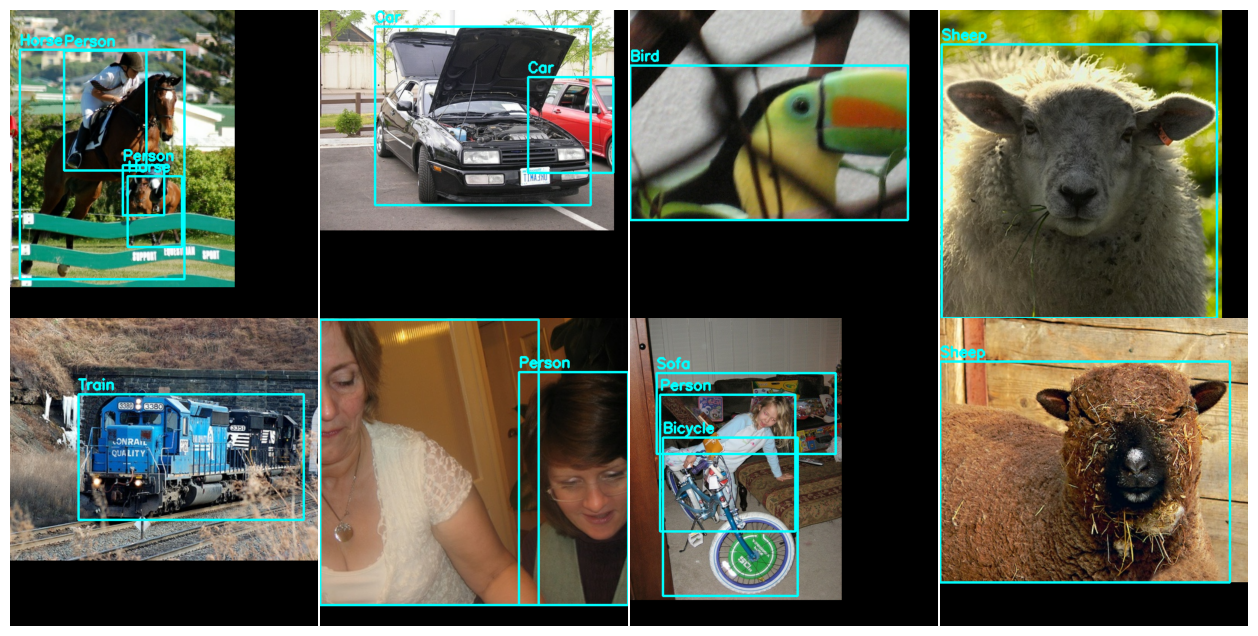

In [170]:
def visualize_dataset(dataset, bounding_box_format):
    example = next(iter(dataset))
    images, boxes = example["images"], example["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=boxes,
        scale=4,
        rows=2,
        cols=4,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
        show=True,
    )

visualize_dataset(train_ds, bounding_box_format="xywh")

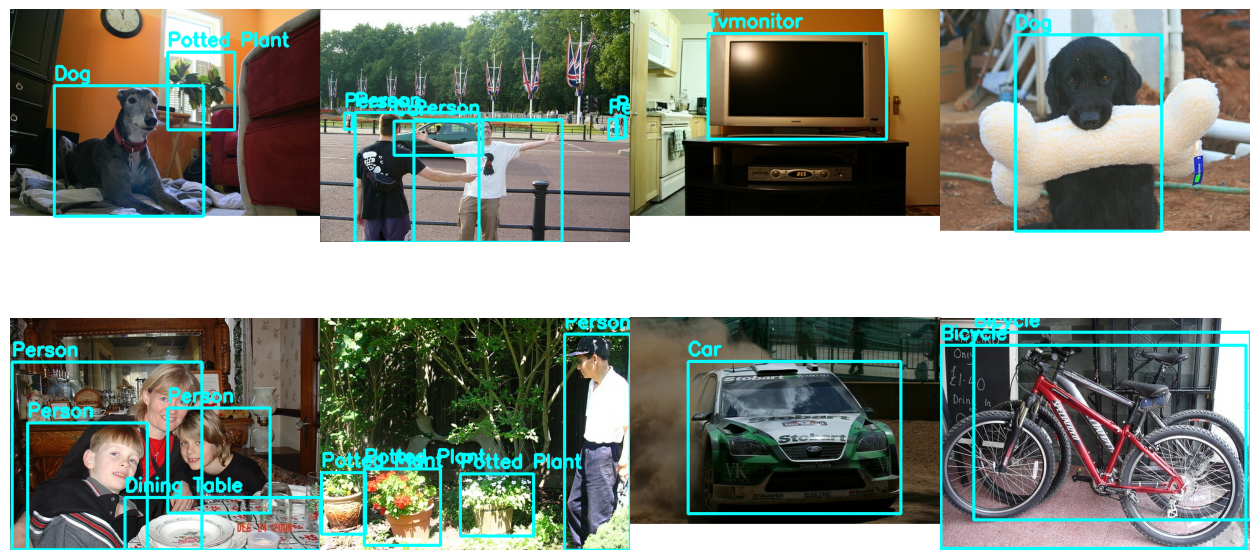

In [171]:
def visualize_dataset(dataset, bounding_box_format):
    example = next(iter(dataset))
    images, boxes = example["images"], example["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=boxes,
        scale=4,
        rows=2,
        cols=4,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
        show=True,
    )

visualize_dataset(eval_ds, bounding_box_format="xywh")

In [172]:
train_ds = train_ds.prefetch(2)
train_ds = train_ds.shuffle(8)
eval_ds = eval_ds.prefetch(2)

In [173]:
def unpackage_dict(inputs):
    return inputs['images'], inputs['bounding_boxes']

In [174]:
train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

In [175]:
model = keras_cv.models.RetinaNet(
    # number of classes to be used in box classification
    classes=20,
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    # KerasCV offers a set of pre-configured backbones
    backbone="resnet50",
    # Each backbone comes with multiple pre-trained weights
    # These weights match the weights available in the `keras_cv.model` class.
    backbone_weights="imagenet",
    # include_rescaling tells the model whether your input images are in the default
    # pixel range (0, 255) or if you have already rescaled your inputs to the range
    # (0, 1).  In our case, we feed our model images with inputs in the range (0, 255).
    include_rescaling=True,
    # Typically, you'll want to set this to False when training a real model.
    # evaluate_train_time_metrics=True makes `train_step()` incompatible with TPU,
    # and also causes a massive performance hit.  It can, however be useful to produce
    # train time metrics when debugging your model training pipeline.
    evaluate_train_time_metrics=False,
)
# Fine-tuning a RetinaNet is as simple as setting backbone.trainable = False
model.backbone.trainable = False

In [176]:
metrics = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        class_ids=range(21),
        bounding_box_format="xywh",
        name="Mean Average Precision",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(21),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]

## Training our model

All that is left to do is train our model.  KerasCV object detection models follow the
standard Keras workflow, leveraging `compile()` and `fit()`.

Let's compile our model:

In [177]:
optimizer = tf.optimizers.SGD(global_clipnorm=10.0)
model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=metrics,
)

Next, we can construct some callbacks:

In [178]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir="logs"),
    keras.callbacks.ReduceLROnPlateau(patience=5),
    # Uncomment to train your own RetinaNet
    keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_weights_only=True),
]

And run `model.fit()`!

In [ ]:
history = model.fit(
    train_ds,
    validation_data=eval_ds.take(10),
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100


# Vizualization

In [ ]:
images, y_true = next(iter(eval_ds.take(1)))
y_pred = model.predict(images)
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format='xywh',
    y_true=y_true,
    y_pred=y_pred,
    scale=4,
    rows=2,
    cols=4,
    show=True,
    thickness=4,
    font_scale=1,
    class_mapping=class_mapping,
)

# Model Evaluation

Lets perform model evaluation.

First, lets plot out the learning curves of our losses and metrics:

Next, we can evaluate the metrics by re-compiling the model, and running
`model.evaluate()`:

In [78]:
import keras_cv
coco_suite = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        bounding_box_format="xywh",
        class_ids=range(20),
        max_detections=100,
        name='MaP Standard'
    ),
    keras_cv.metrics.COCOMeanAveragePrecision(
        bounding_box_format="xywh",
        class_ids=range(20),
        iou_thresholds=[0.75],
        max_detections=100,
        name='MaP@IoU=0.75'
    ),
    keras_cv.metrics.COCOMeanAveragePrecision(
        bounding_box_format="xywh",
        class_ids=range(20),
        iou_thresholds=[0.5],
        max_detections=100,
        name='MaP@IoU=0.5'
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(20),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]

In [79]:
model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=coco_suite,
)

In [84]:
from pycocotools import coco
from pycocotools import cocoeval

In [81]:
model.load_weights(CHECKPOINT_PATH)

In [83]:
keras_cv_metrics = model.evaluate(eval_ds, return_dict=True)
print(keras_cv_metrics)

  6/619 [..............................] - ETA: 21:45 - MaP Standard: 0.4538 - MaP@IoU=0.75: 0.5433 - MaP@IoU=0.5: 0.6086 - Recall: 0.5320 - loss: 3.1457 - classification_loss: 1.3192 - box_loss: 1.8265 - regularization_loss: 0.0000e+00

KeyboardInterrupt: 

In [134]:
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import six
import tensorflow_datasets as tfds

from pycocotools import coco
from pycocotools import cocoeval
from PIL import Image
import copy
import keras_cv
import keras_cv.layers
from keras_cv import bounding_box
from keras.utils import data_utils


import numpy as np
import six
class COCOWrapper(coco.COCO):
  """COCO wrapper class.
  This class wraps COCO API object, which provides the following additional
  functionalities:
    1. Support string type image id.
    2. Support loading the groundtruth dataset using the external annotation
       dictionary.
    3. Support loading the prediction results using the external annotation
       dictionary.
  """

  def __init__(self, gt_dataset=None):
    """Instantiates a COCO-style API object.
    Args:
      eval_type: either 'box' or 'mask'.
      annotation_file: a JSON file that stores annotations of the eval dataset.
        This is required if `gt_dataset` is not provided.
      gt_dataset: the groundtruth eval datatset in COCO API format.
    """

    coco.COCO.__init__(self, annotation_file=None)
    self._eval_type = 'box'
    if gt_dataset:
      self.dataset = gt_dataset
      self.createIndex()

  def loadRes(self, predictions):
    """Loads result file and return a result api object.
    Args:
      predictions: a list of dictionary each representing an annotation in COCO
        format. The required fields are `image_id`, `category_id`, `score`,
        `bbox`, `segmentation`.
    Returns:
      res: result COCO api object.
    Raises:
      ValueError: if the set of image id from predctions is not the subset of
        the set of image id of the groundtruth dataset.
    """
    res = coco.COCO()
    res.dataset['images'] = copy.deepcopy(self.dataset['images'])
    res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])

    image_ids = [ann['image_id'] for ann in predictions]
    if set(image_ids) != (set(image_ids) & set(self.getImgIds())):
      raise ValueError('Results do not correspond to the current dataset!')
    for ann in predictions:
      x1, x2, y1, y2 = [ann['bbox'][0], ann['bbox'][0] + ann['bbox'][2],
                        ann['bbox'][1], ann['bbox'][1] + ann['bbox'][3]]

      ann['area'] = ann['bbox'][2] * ann['bbox'][3]
      ann['segmentation'] = [
          [x1, y1, x1, y2, x2, y2, x2, y1]]

    res.dataset['annotations'] = copy.deepcopy(predictions)
    res.createIndex()
    return res

def yxyx_to_xywh(boxes):
  if boxes.shape[-1] != 4:
    raise ValueError(
        'boxes.shape[-1] is {:d}, but must be 4.'.format(boxes.shape[-1]))

  boxes_ymin = boxes[..., 0]
  boxes_xmin = boxes[..., 1]
  boxes_width = boxes[..., 3] - boxes[..., 1]
  boxes_height = boxes[..., 2] - boxes[..., 0]
  new_boxes = np.stack(
      [boxes_xmin, boxes_ymin, boxes_width, boxes_height], axis=-1)

  return new_boxes

def convert_predictions_to_coco_annotations(predictions):
  coco_predictions = []
  num_batches = len(predictions['source_id'])
  max_num_detections = predictions['detection_classes'][0].shape[1]
  use_outer_box = 'detection_outer_boxes' in predictions
  for i in range(num_batches):
    predictions['detection_boxes'][i] = yxyx_to_xywh(
        predictions['detection_boxes'][i])
    if use_outer_box:
      predictions['detection_outer_boxes'][i] = yxyx_to_xywh(
          predictions['detection_outer_boxes'][i])
      mask_boxes = predictions['detection_outer_boxes']
    else:
      mask_boxes = predictions['detection_boxes']

    batch_size = predictions['source_id'][i].shape[0]
    for j in range(batch_size):
      for k in range(max_num_detections):
        ann = {}
        ann['image_id'] = predictions['source_id'][i][j]
        ann['category_id'] = predictions['detection_classes'][i][j, k]
        ann['bbox'] = predictions['detection_boxes'][i][j, k]
        ann['score'] = predictions['detection_scores'][i][j, k]
        coco_predictions.append(ann)

  for i, ann in enumerate(coco_predictions):
    ann['id'] = i + 1

  return coco_predictions

def convert_groundtruths_to_coco_dataset(groundtruths, label_map=None):
  source_ids = np.concatenate(groundtruths['source_id'], axis=0)
  heights = np.concatenate(groundtruths['height'], axis=0)
  widths = np.concatenate(groundtruths['width'], axis=0)
  gt_images = [{'id': int(i), 'height': int(h), 'width': int(w)} for i, h, w
               in zip(source_ids, heights, widths)]

  gt_annotations = []
  num_batches = len(groundtruths['source_id'])
  for i in range(num_batches):
    max_num_instances = groundtruths['classes'][i].shape[1]
    batch_size = groundtruths['source_id'][i].shape[0]
    for j in range(batch_size):
      num_instances = groundtruths['num_detections'][i][j]
      if num_instances > max_num_instances:
        num_instances = max_num_instances
      for k in range(int(num_instances)):
        ann = {}
        ann['image_id'] = int(groundtruths['source_id'][i][j])
        if 'is_crowds' in groundtruths:
          ann['iscrowd'] = int(groundtruths['is_crowds'][i][j, k])
        else:
          ann['iscrowd'] = 0
        ann['category_id'] = int(groundtruths['classes'][i][j, k])
        boxes = groundtruths['boxes'][i]
        ann['bbox'] = [
            float(boxes[j, k, 1]),
            float(boxes[j, k, 0]),
            float(boxes[j, k, 3] - boxes[j, k, 1]),
            float(boxes[j, k, 2] - boxes[j, k, 0])]
        if 'areas' in groundtruths:
          ann['area'] = float(groundtruths['areas'][i][j, k])
        else:
          ann['area'] = float(
              (boxes[j, k, 3] - boxes[j, k, 1]) *
              (boxes[j, k, 2] - boxes[j, k, 0]))
        gt_annotations.append(ann)

  for i, ann in enumerate(gt_annotations):
    ann['id'] = i + 1

  if label_map:
    gt_categories = [{'id': i, 'name': label_map[i]} for i in label_map]
  else:
    category_ids = [gt['category_id'] for gt in gt_annotations]
    gt_categories = [{'id': i} for i in set(category_ids)]

  gt_dataset = {
      'images': gt_images,
      'categories': gt_categories,
      'annotations': copy.deepcopy(gt_annotations),
  }
  return gt_dataset

class COCOEvaluator(object):
  """COCO evaluation metric class."""

  def __init__(self,
               per_category_metrics=False):
    self._per_category_metrics = per_category_metrics
    self._metric_names = [
        'AP', 'AP50', 'AP75', 'APs', 'APm', 'APl', 'ARmax1', 'ARmax10',
        'ARmax100', 'ARs', 'ARm', 'ARl'
    ]
    self._required_prediction_fields = [
        'source_id', 'num_detections', 'detection_classes', 'detection_scores',
        'detection_boxes'
    ]
    self._required_groundtruth_fields = [
        'source_id', 'height', 'width', 'classes', 'boxes'
    ]

    self.reset_states()

  def reset_states(self):
    """Resets internal states for a fresh run."""
    self._predictions = {}
    self._groundtruths = {}

  def result(self):
    """Evaluates detection results, and reset_states."""
    metric_dict = self.evaluate()
    # Cleans up the internal variables in order for a fresh eval next time.
    self.reset_states()
    return metric_dict

  def evaluate(self):
    """Evaluates with detections from all images with COCO API.
    Returns:
      coco_metric: float numpy array with shape [24] representing the
        coco-style evaluation metrics (box and mask).
    """
    gt_dataset = convert_groundtruths_to_coco_dataset(
        self._groundtruths)
    coco_gt = COCOWrapper(
        gt_dataset=gt_dataset)
    coco_predictions = convert_predictions_to_coco_annotations(
        self._predictions)
    coco_dt = coco_gt.loadRes(predictions=coco_predictions)
    image_ids = [ann['image_id'] for ann in coco_predictions]

    coco_eval = cocoeval.COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.imgIds = image_ids
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    coco_metrics = coco_eval.stats

    metrics = coco_metrics

    metrics_dict = {}
    for i, name in enumerate(self._metric_names):
      metrics_dict[name] = metrics[i].astype(np.float32)

    # Adds metrics per category.
    if self._per_category_metrics:
      metrics_dict.update(self._retrieve_per_category_metrics(coco_eval))

    return metrics_dict

  def _retrieve_per_category_metrics(self, coco_eval, prefix=''):
    """Retrieves and per-category metrics and retuns them in a dict.
    Args:
      coco_eval: a cocoeval.COCOeval object containing evaluation data.
      prefix: str, A string used to prefix metric names.
    Returns:
      metrics_dict: A dictionary with per category metrics.
    """

    metrics_dict = {}
    if prefix:
      prefix = prefix + ' '

    if hasattr(coco_eval, 'category_stats'):
      for category_index, category_id in enumerate(coco_eval.params.catIds):
        category_display_name = category_id

        metrics_dict[prefix + 'Precision mAP ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[0][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory@50IoU/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[1][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory@75IoU/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[2][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory (small) /{}'.format(
            category_display_name
        )] = coco_eval.category_stats[3][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory (medium) /{}'.format(
            category_display_name
        )] = coco_eval.category_stats[4][category_index].astype(np.float32)
        metrics_dict[prefix + 'Precision mAP ByCategory (large) /{}'.format(
            category_display_name
        )] = coco_eval.category_stats[5][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR@1 ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[6][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR@10 ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[7][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR@100 ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[8][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR (small) ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[9][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR (medium) ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[10][category_index].astype(np.float32)
        metrics_dict[prefix + 'Recall AR (large) ByCategory/{}'.format(
            category_display_name
        )] = coco_eval.category_stats[11][category_index].astype(np.float32)

    return metrics_dict

  def _convert_to_numpy(self, groundtruths, predictions):
    """Converts tesnors to numpy arrays."""
    if groundtruths:
      labels = tf.nest.map_structure(lambda x: x.numpy(), groundtruths)
      numpy_groundtruths = {}
      for key, val in labels.items():
        if isinstance(val, tuple):
          val = np.concatenate(val)
        numpy_groundtruths[key] = val
    else:
      numpy_groundtruths = groundtruths

    if predictions:
      outputs = tf.nest.map_structure(lambda x: x.numpy(), predictions)
      numpy_predictions = {}
      for key, val in outputs.items():
        if isinstance(val, tuple):
          val = np.concatenate(val)
        numpy_predictions[key] = val
    else:
      numpy_predictions = predictions

    return numpy_groundtruths, numpy_predictions

  def update_state(self, groundtruths, predictions):
    """Update and aggregate detection results and groundtruth data.
    Args:
      groundtruths: a dictionary of Tensors including the fields below.
        See also different parsers under `../dataloader` for more details.
        Required fields:
          - source_id: a numpy array of int or string of shape [batch_size].
          - height: a numpy array of int of shape [batch_size].
          - width: a numpy array of int of shape [batch_size].
          - num_detections: a numpy array of int of shape [batch_size].
          - boxes: a numpy array of float of shape [batch_size, K, 4].
          - classes: a numpy array of int of shape [batch_size, K].
        Optional fields:
          - is_crowds: a numpy array of int of shape [batch_size, K]. If the
              field is absent, it is assumed that this instance is not crowd.
          - areas: a numy array of float of shape [batch_size, K]. If the
              field is absent, the area is calculated using either boxes or
              masks depending on which one is available.
          - masks: a numpy array of float of shape
              [batch_size, K, mask_height, mask_width],
      predictions: a dictionary of tensors including the fields below.
        See different parsers under `../dataloader` for more details.
        Required fields:
          - source_id: a numpy array of int or string of shape [batch_size].
          - image_info [if `need_rescale_bboxes` is True]: a numpy array of
            float of shape [batch_size, 4, 2].
          - num_detections: a numpy array of
            int of shape [batch_size].
          - detection_boxes: a numpy array of float of shape [batch_size, K, 4].
          - detection_classes: a numpy array of int of shape [batch_size, K].
          - detection_scores: a numpy array of float of shape [batch_size, K].
        Optional fields:
          - detection_masks: a numpy array of float of shape
              [batch_size, K, mask_height, mask_width].
    Raises:
      ValueError: if the required prediction or groundtruth fields are not
        present in the incoming `predictions` or `groundtruths`.
    """
    groundtruths, predictions = self._convert_to_numpy(groundtruths,
                                                       predictions)
    for k in self._required_prediction_fields:
      if k not in predictions:
        raise ValueError(
            'Missing the required key `{}` in predictions!'.format(k))
    for k, v in six.iteritems(predictions):
      if k not in self._predictions:
        self._predictions[k] = [v]
      else:
        self._predictions[k].append(v)

    assert groundtruths
    for k in self._required_groundtruth_fields:
      if k not in groundtruths:
        raise ValueError(
            'Missing the required key `{}` in groundtruths!'.format(k))
    for k, v in six.iteritems(groundtruths):
      if k not in self._groundtruths:
        self._groundtruths[k] = [v]
      else:
        self._groundtruths[k].append(v)

In [146]:
eval_ds = tfds.load("voc/2007", split="test", with_info=False, shuffle_files=True)

In [147]:
def proc_eval_fn(bounding_box_format, img_size):
    resizing = tf.keras.layers.Resizing(
        height=img_size[0], width=img_size[1], crop_to_aspect_ratio=False
    )

    def apply(inputs):
        source_id = tf.strings.to_number(
            tf.strings.split(inputs["image/filename"], '.')[0], tf.int64)
        raw_image = inputs["image"]
        raw_image = tf.cast(raw_image, tf.float32)
        image = resizing(raw_image)
        gt_boxes = keras_cv.bounding_box.convert_format(
            inputs["objects"]["bbox"],
            images=image,
            source="rel_yxyx",
            target=bounding_box_format,
        )
        gt_classes = tf.cast(inputs["objects"]["label"], tf.float32)
        gt_classes = tf.expand_dims(gt_classes, axis=-1)
        return {
            "source_id": source_id,
            "raw_images": raw_image,
            "images": image,
            "gt_boxes": gt_boxes,
            "gt_classes": gt_classes,
        }

    return apply

In [148]:
def pad_fn(examples):
    gt_boxes = examples.pop("gt_boxes")
    gt_classes = examples.pop("gt_classes")
    examples["gt_boxes"] = gt_boxes.to_tensor(default_value=-1.0)
    examples["gt_classes"] = gt_classes.to_tensor(default_value=-1.0)
    return examples

In [149]:
eval_ds = eval_ds.map(
    proc_eval_fn("xywh", [640, 640, 3]), num_parallel_calls=tf.data.AUTOTUNE
)
eval_ds = eval_ds.apply(
    tf.data.experimental.dense_to_ragged_batch(8, drop_remainder=True)
)
eval_ds = eval_ds.map(pad_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [151]:
evaluator = COCOEvaluator()

def eval_pycoco_step(examples):
    images = examples["images"]
    gt_boxes = examples["gt_boxes"]
    gt_classes = examples["gt_classes"]
    ground_truth = {}
    ground_truth["source_id"] = examples["source_id"]
    ground_truth["height"] = tf.tile(tf.constant([640]), [8])
    ground_truth["width"] = tf.tile(tf.constant([640]), [8])
    num_dets = gt_classes.get_shape().as_list()[1]
    ground_truth["num_detections"] = tf.tile(tf.constant([num_dets]), [8])
    ground_truth["boxes"] = gt_boxes
    ground_truth["classes"] = gt_classes

    y_pred = model.predict(images)
    y_pred = y_pred.to_tensor(-1)
    
    predictions = {}
    predictions["source_id"] = examples["source_id"]
    predictions["num_detections"] = tf.tile([y_pred.shape.as_list()[1]], [8])
    predictions["detection_boxes"] = y_pred[:, :, :4]
    predictions["detection_classes"] = y_pred[:, :, 4]
    predictions["detection_scores"] = y_pred[:, :, 5]

    evaluator.update_state(ground_truth, predictions)

In [152]:
for examples in eval_ds.take(1):
    eval_pycoco_step(examples)

1/1 [==============================] - 0s 108ms/step


In [153]:
print("MAP {}".format(evaluator.result()))

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av